In [1]:
%matplotlib inline

In [2]:
# import nltk
# nltk.download()

In [3]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import operator 
from collections import defaultdict
import re

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler, Stream
import json

from sklearn.linear_model import SGDClassifier

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn import preprocessing

Using TensorFlow backend.


## Question 1

### Download the dataset:

In [4]:
# import csv file
csvfile = 'gender-classifier-DFE-791531.csv'
data = pd.read_csv(csvfile, encoding='latin-1')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


### Perform text pre-processing:

In [5]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation
ps = PorterStemmer()
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    try:
        s=s.encode(encoding='ascii',errors='ignore')
    except:
        s=s
    return re.findall(pattern=tokens_re,string=s.decode('ascii'))
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [ps.stem(token) for token in tokens]
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [6]:
df = data[['text','gender']]
df.dropna(inplace=True)
df = df[df.gender != 'unknown']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
terms_male = Counter()
terms_female = Counter()
terms_brand = Counter()
terms_all_genders = Counter()

dic = {'male' : terms_male, 'female' : terms_female, 'brand' : terms_brand}
for index, row in df.iterrows():
    terms_all = [term for term in preprocess(row['text'],True) if term not in stop]
    dic[row['gender']].update(terms_all)
    terms_all_genders.update(terms_all)

### Present data exploration:

### class distribution:

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64


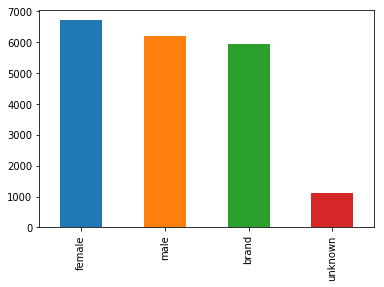

In [8]:
print(data['gender'].value_counts())
pd.value_counts(data['gender']).plot.bar()

### present the country which was most popular in the training data:

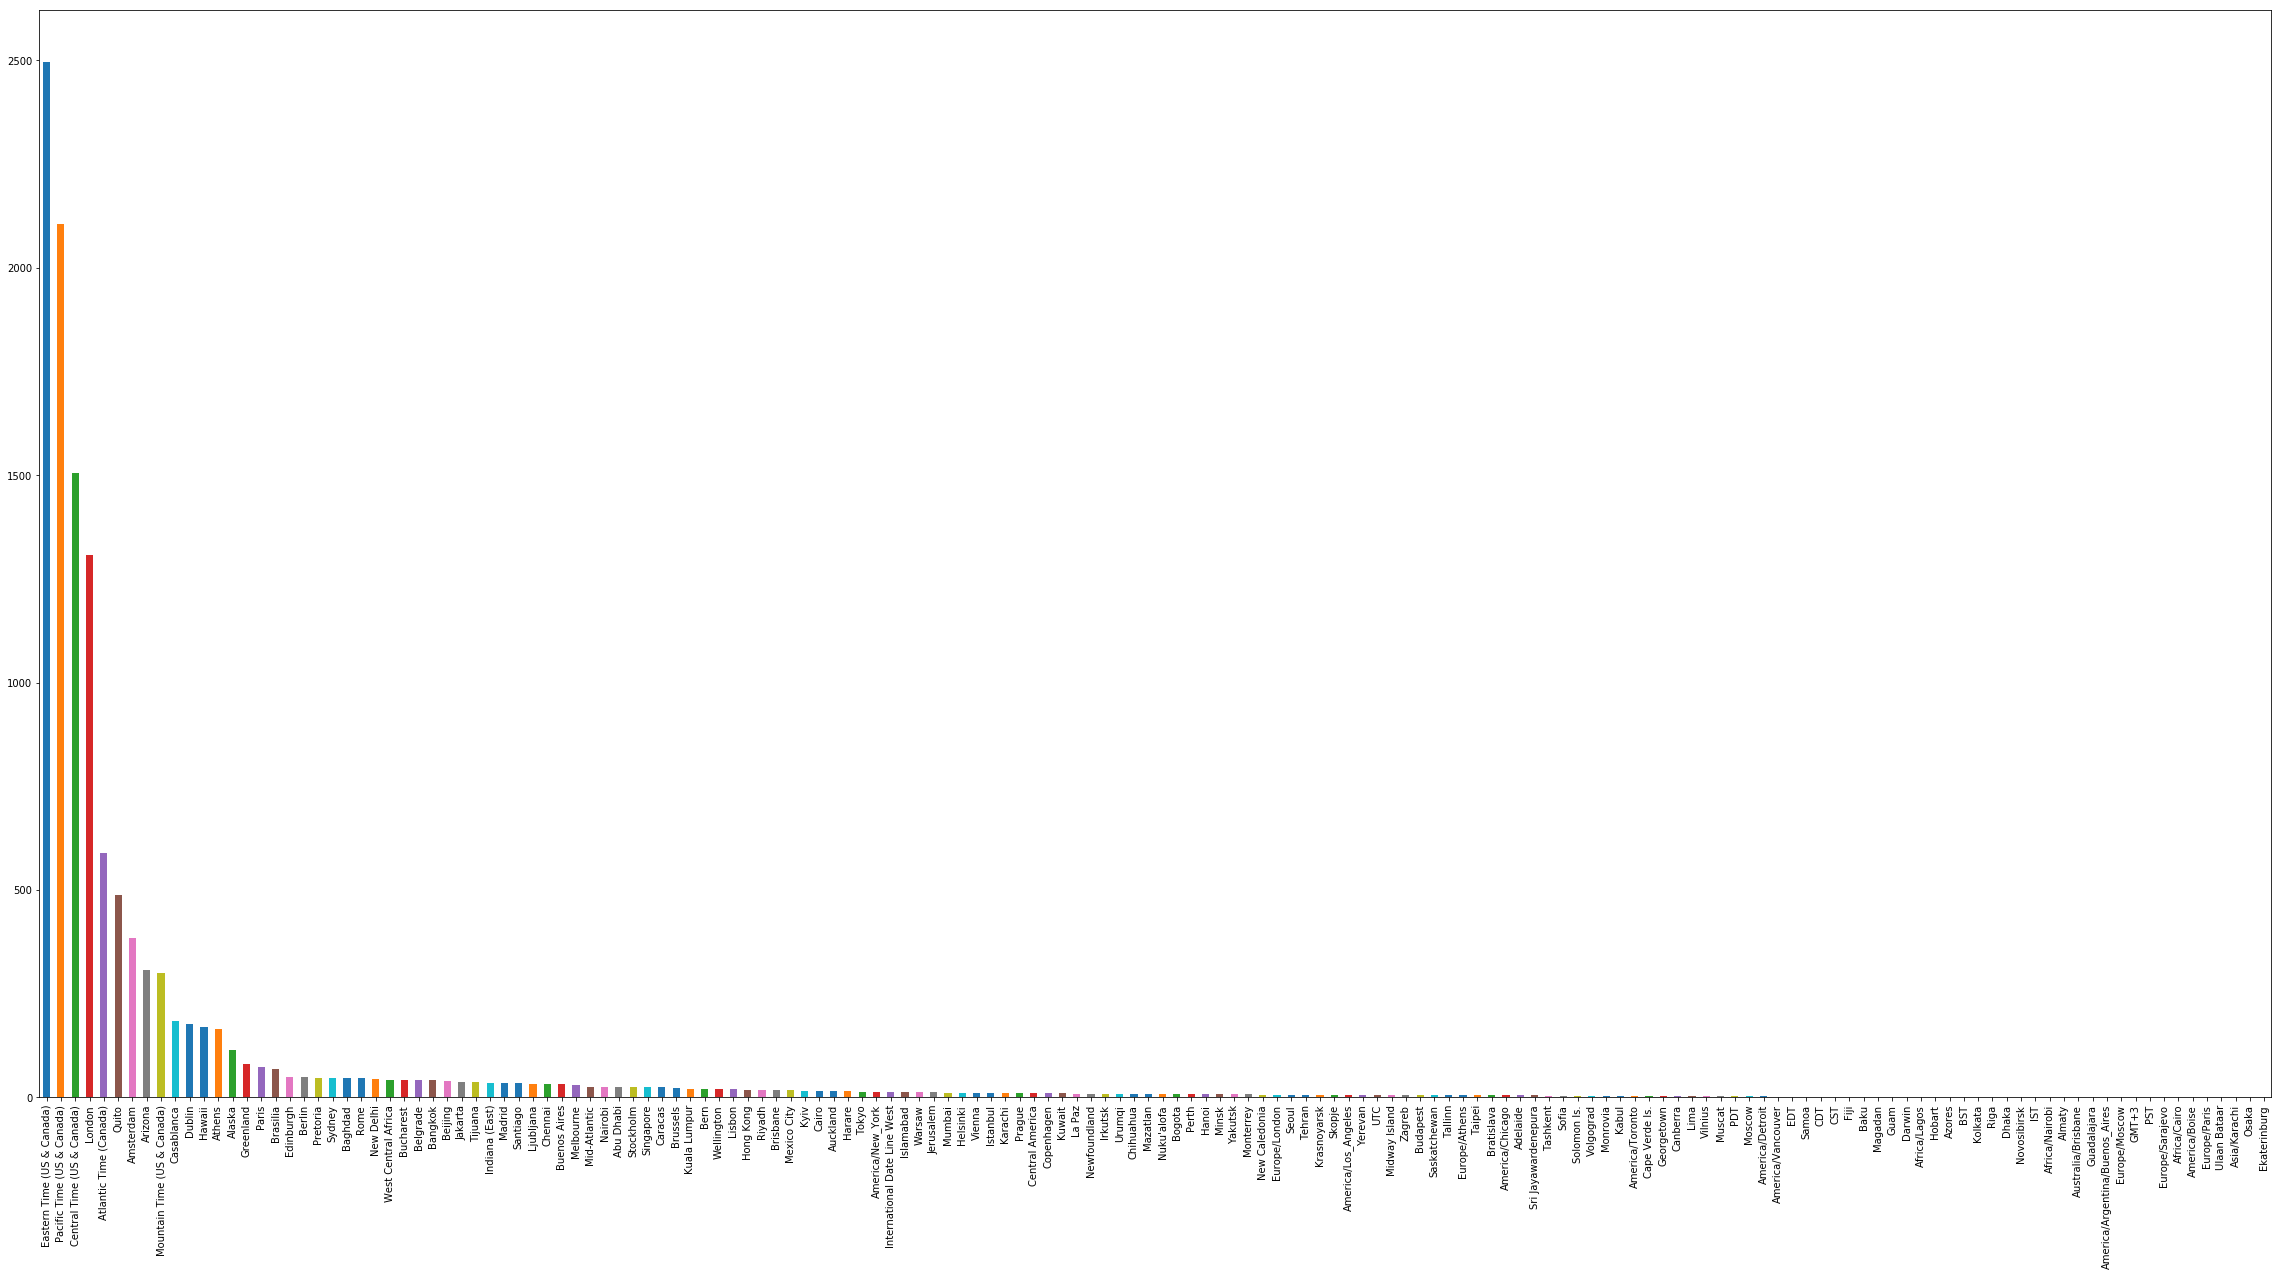

In [9]:
plt.figure(figsize=(40,20))
pd.value_counts(data['user_timezone']).plot.bar()

### terms frequency for the different genders:

Text(0, 0.5, 'frequency')

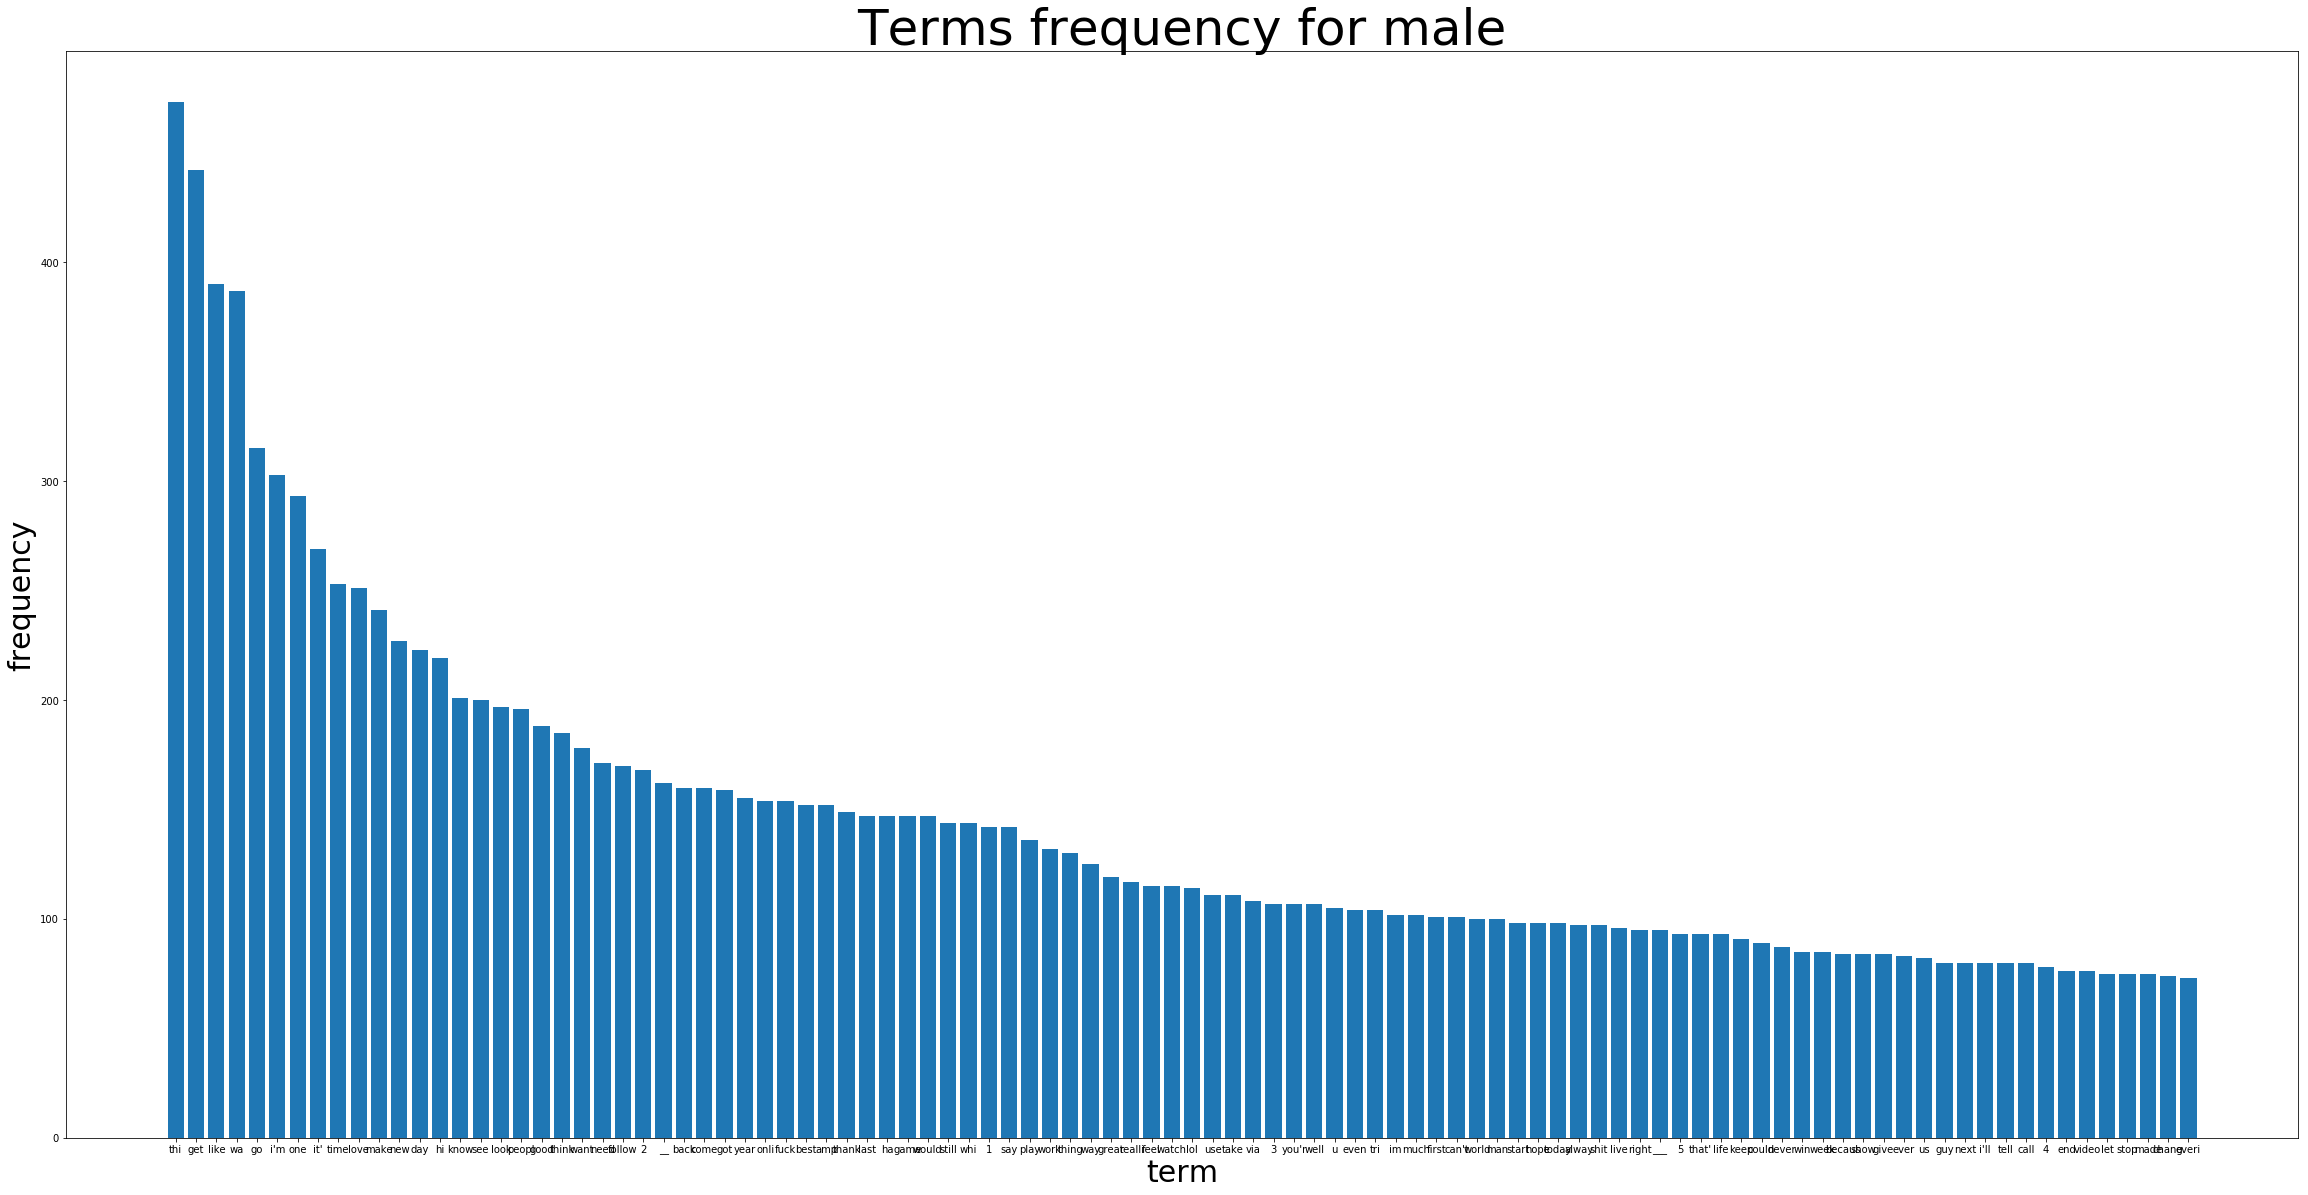

In [10]:
# present terms frequency for male
keys = []
values = []
for x, y in terms_male.most_common(100):
    keys.append(x)
    values.append(y)
plt.figure(figsize=(40,20))
plt.bar(keys, values)
plt.title("Terms frequency for male", fontsize=50)
plt.xlabel("term", fontsize=30)
plt.ylabel("frequency", fontsize=30)

Text(0, 0.5, 'frequency')

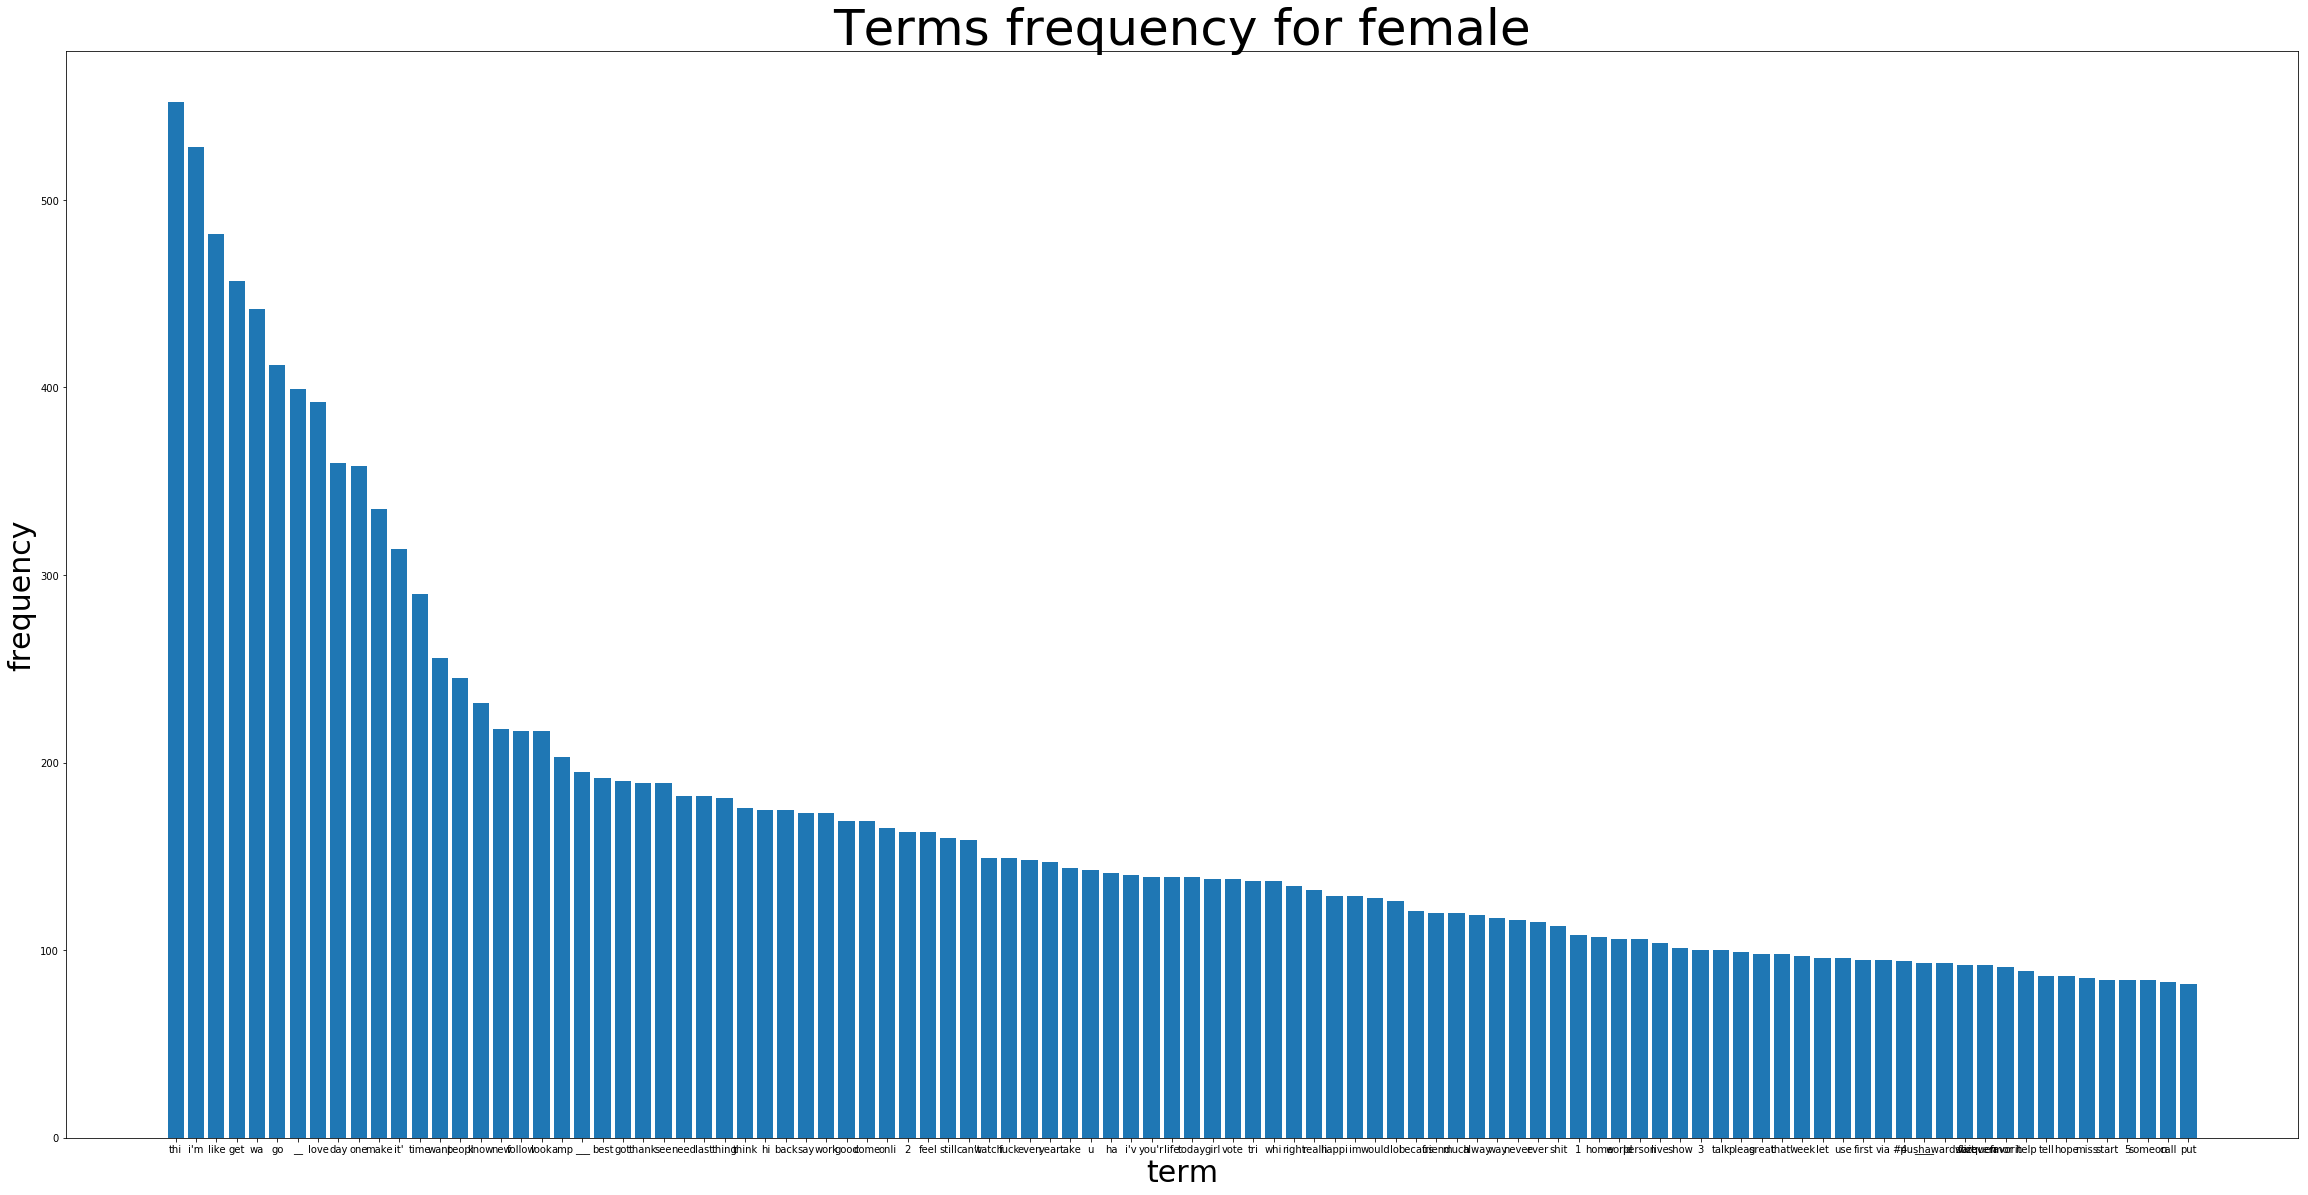

In [11]:
# present terms frequency for female
keys = []
values = []
for x, y in terms_female.most_common(100):
    keys.append(x)
    values.append(y)
plt.figure(figsize=(40,20))
plt.bar(keys, values)
plt.title("Terms frequency for female", fontsize=50)
plt.xlabel("term", fontsize=30)
plt.ylabel("frequency", fontsize=30)

## Question 2

### Train a machine learning model to predict the gender of the tweet author.

In [12]:
# split to train and test
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
y_train, y_test = train.gender, test.gender

In [13]:
# Extracting features train and test
print("Extracting features from the training data using a sparse vectorizer")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_train = vectorizer.fit_transform(train.text)

print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
X_test = vectorizer.transform(test.text)
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the training data using a sparse vectorizer
n_samples: 15078, n_features: 35018

Extracting features from the test data using the same vectorizer
n_samples: 3758, n_features: 35018



In [14]:
def benchmark(clf, X_train, y_train, X_test, y_test):
    print('_' * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)
    test_pred = clf.predict(X_test)
    train_pred = clf.predict(X_train)

    test_score = metrics.accuracy_score(y_test, test_pred)
    train_score = metrics.accuracy_score(y_train, train_pred)
    print("test accuracy:   %0.3f" % test_score)
    print("train accuracy:   %0.3f" % test_score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, train_score, test_score

In [15]:
# fit SVM and Perceptron models
results = []
for clf, name in (
        (SGDClassifier(max_iter=10),"SVM"),
        (Perceptron(max_iter=10), "Perceptron")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train, y_train, X_test, y_test))

SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
test accuracy:   0.548
train accuracy:   0.548

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=10, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)
test accuracy:   0.501
train accuracy:   0.501



In [16]:
# fit Deep Learning model
le = preprocessing.LabelEncoder()
le.fit(y_train)

print('=' * 80)
print("Sequential")
print('_' * 80)
print("Training: ")
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(X_train, to_categorical(le.transform(y_train)), validation_split=0.25, shuffle=True, epochs=3)
test_score = metrics.accuracy_score(le.transform(y_test), model.predict_classes(X_test))
train_score = metrics.accuracy_score(le.transform(y_train), model.predict_classes(X_train))
print("test accuracy:   %0.3f" % test_score)
print("train accuracy:   %0.3f" % train_score)
print()
results.append(('Deep Learning',train_score, test_score))

Sequential
________________________________________________________________________________
Training: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                350190    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 350,333
Trainable params: 350,333
Non-trainable params: 0
_________________________________________________________________
Train on 11308 samples, validate on 3770 samples
Epoch 1/3
11308/11308 [==============================] - 13s 1ms/step - loss: 1.0107 - acc: 0.4712 - val_loss: 0.9922 - val_acc: 0.5085
Epoch 2/3
11308/11308 [==============================] - 13s 1ms/step - loss: 0.7714 - acc: 0.6380 - val_loss: 1

## tune parameters:

In [17]:
parameters =  {'vect__max_df': (0.3,0.4,0.5),'clf__alpha': (0.001, 0.01,1.0)}

In [18]:
# SVM
nb_clf = Pipeline([('vect', TfidfVectorizer()),('clf', SGDClassifier(max_iter=10))])
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1)
gs_clf = gs_clf.fit(train.text,train.gender)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best score:  0.5265950391298581
Best params:  {'clf__alpha': 0.001, 'vect__max_df': 0.5}


In [19]:
# Perceptron
nb_clf = Pipeline([('vect', TfidfVectorizer()),('clf', Perceptron(max_iter=10))])
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1)
gs_clf = gs_clf.fit(train.text,train.gender)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best score:  0.4844143785647964
Best params:  {'clf__alpha': 0.001, 'vect__max_df': 0.4}


### Present train and test accuracy for different model:

In [20]:
# train and test accuracy
df_results = pd.DataFrame(results, columns=['Model','Train Accuracy','Test Accuracy'])
df_results

,Model,Train Accuracy,Test Accuracy
0,SGDClassifier,0.873657,0.548164
1,Perceptron,0.986338,0.500798
2,Deep Learning,0.828956,0.522618


## Question 3

### Use Twitter streaming API to collect 15,000 tweets from the country which was most popular in the training data:

In [21]:
#Variables that contains the user credentials to access Twitter API 
consumer_key='GFVoG2WrusR9TxXOkO1sWXqBz'
consumer_secret='cOWwZRiyV1jwadldkoVVNoOHmpaYViw9CqPcnmQTvjvEFkam21'
access_token='1082610684578488320-eeFIYjm3EFA7JGlbnabDhgY8DTRy2y'
access_token_secret='J0SY0OaFwVDkMqDTykI1Qerrcf86ASAD52CX8aG2BC8Nu'
json_data=[]
names=[]
screen_names=[]
texts=[]
hashtags=[]
LIMIT_OF_TWEETS=15000

#This is a basic listener that just prints received tweets to stdout.
class StdOutListener(StreamListener):

    def on_data(self, data):
        if(len(json_data)<LIMIT_OF_TWEETS):
            tweet = json.loads(data)
            json_data.append(tweet)
            names.append(tweet['user']['name'])
            screen_names.append(tweet['user']['screen_name'])
            texts.append(tweet['text'])
            hashtags.append(tweet['entities']['hashtags'])
            return True
        else:
            stream.disconnect() #after collext 15000 tweets disconnect

    def on_error(self, status):
        print (status)


if __name__ == '__main__':
    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)
    #This line filter Twitter Streams to capture data by the most popular location in training data'
    #the most popular is US & Canada
    stream.filter(locations=[-162.8,28.2,-64.4,71.6])
    df = pd.DataFrame({'name': names, 'screen_name': screen_names,'text': texts,'hashtags':hashtags })
    #df.set_index('index')
    display(df)
    #important to the continue
    #row=df.loc[ 1 , : ]
    #display(row)
    #print(row['name'])
    print('done')    

,name,screen_name,text,hashtags
0,AlvarezNestor,alvareznestor,Esta es una de las tantas personas que se lucr...,[]
1,austyn,_poopeye,Idk how mfs ain’t learning 😂😭😭stuuuupidddd,[]
2,Keith Rettig,KeithRettig2,Shows just how far out of touch she is unreal,[]
3,Nellie,nell20_45,@TravisAllen02 I love how petty this is https:...,[]
4,"John Halloran, SCPS",Halloran_J,Fred Rogers would approve,[]
5,Adonis,AdonisG07,Give this a quick read please😁 https://t.co/hP...,[]
6,Ann Marie White,AnnMari11331462,@JackConnie @PenelopeRuzy @BravoHWFanClub Than...,[]
7,Ellen Stanton,judecreek2,@krassenstein @realDonaldTrump Unlike Hillary....,[]
8,MrBowler,rgcappy1,@southerndivine Not. Of. The. Time.,[]
9,Stefan Pokorny,stefandwarven,@Quil244 https://t.co/c6UzJaMfX5,[]


done


### Repeat the same pre-processing you implemented in Question 1 for the collected tweets:

In [22]:
terms_tweets = Counter()
for index, row in df.iterrows():
    terms_all = [term for term in preprocess(row['text'],True) if term not in stop]
    terms_tweets.update(terms_all)

### Present terms frequency:

Text(0, 0.5, 'frequency')

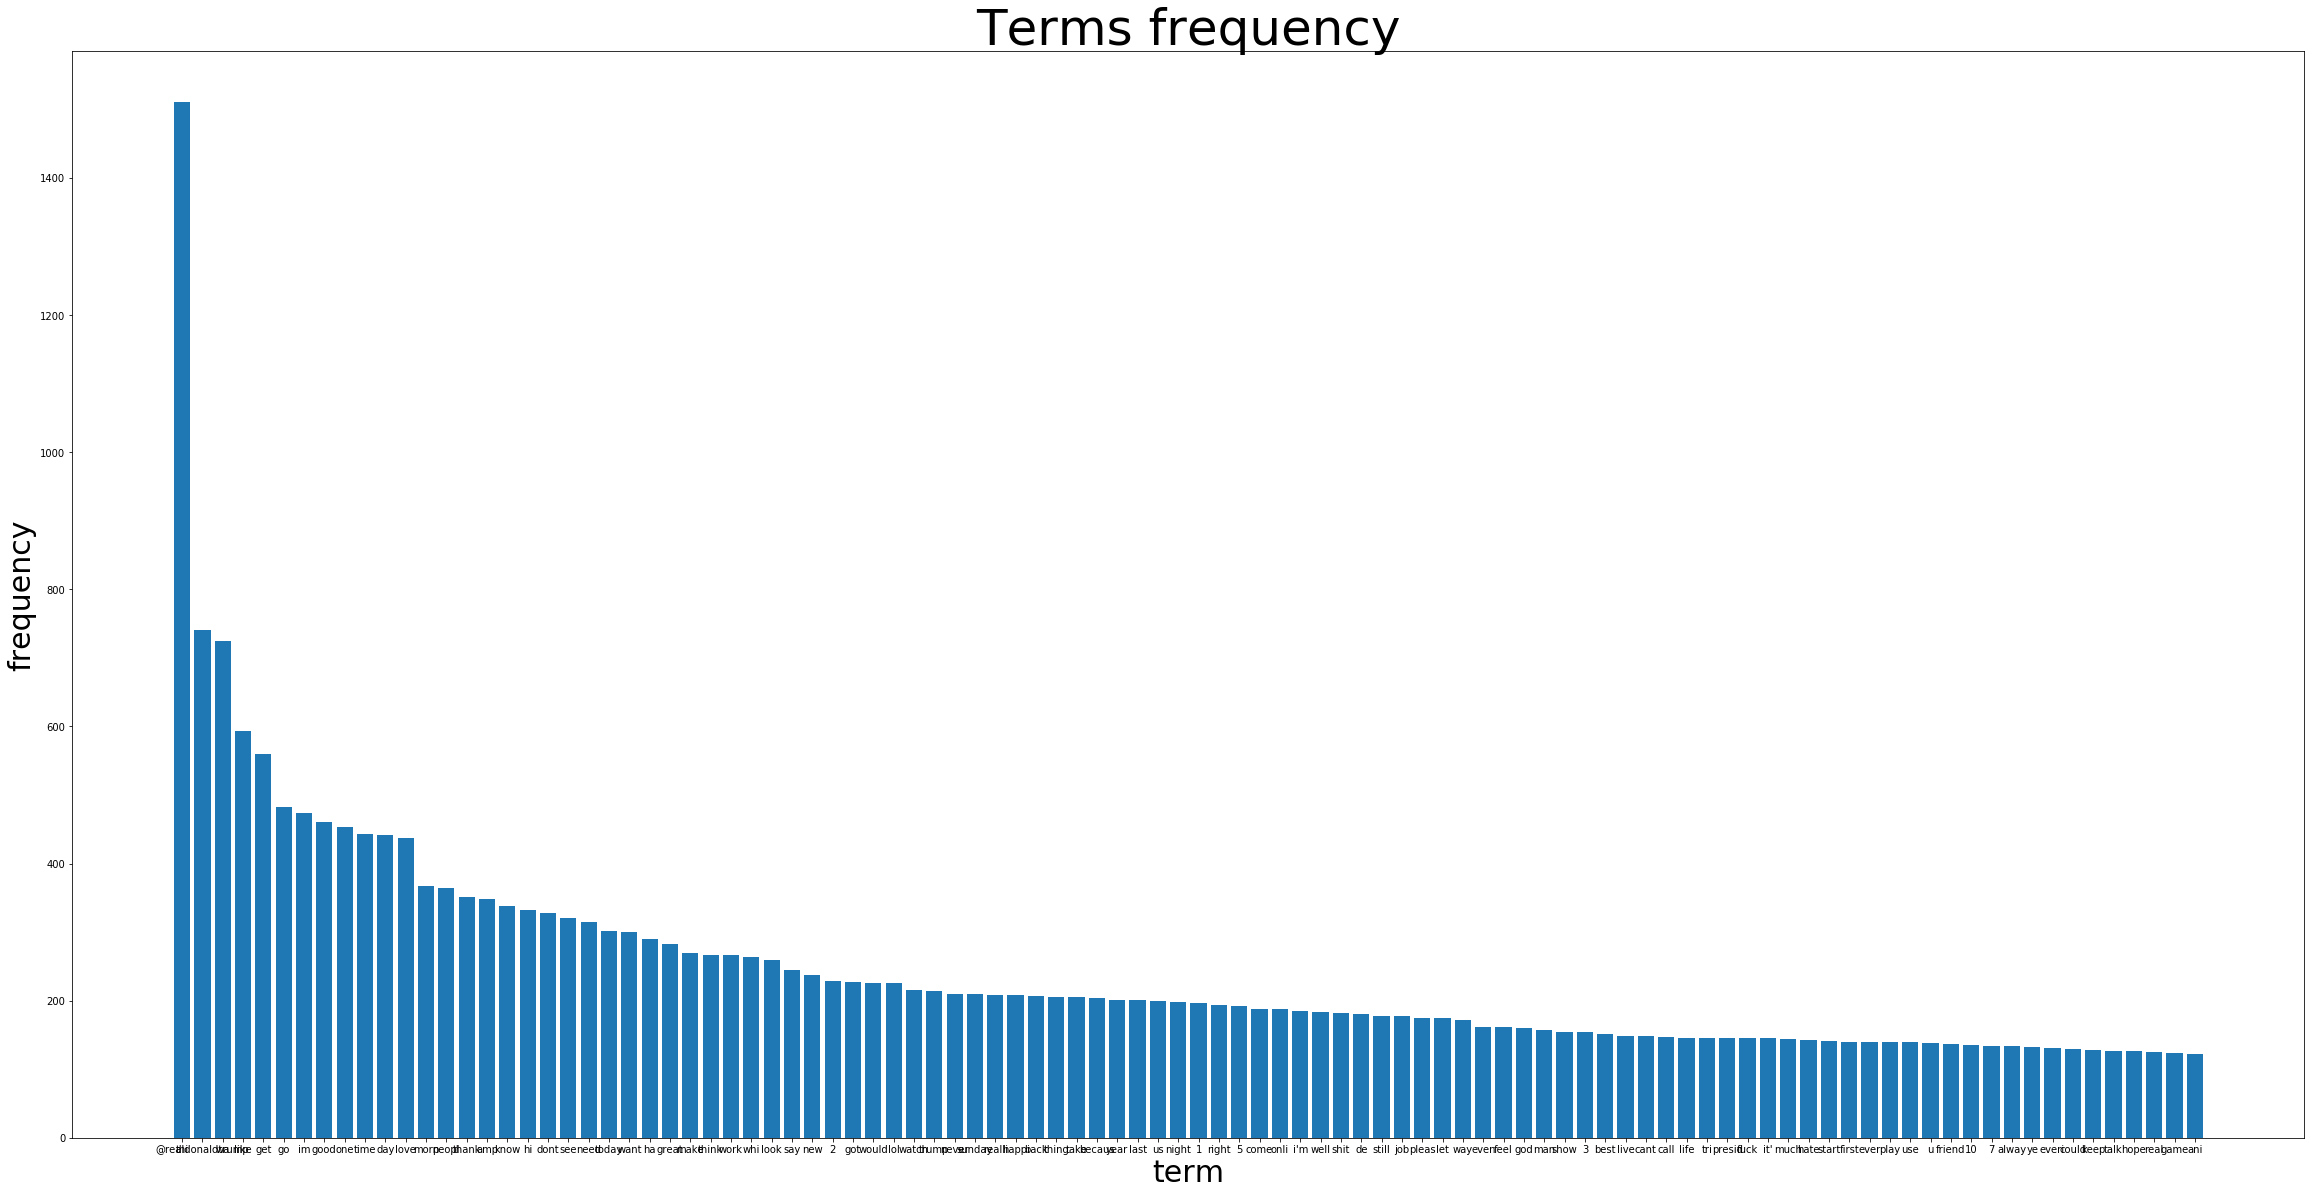

In [23]:
keys = []
values = []
for x, y in terms_tweets.most_common(100):
    keys.append(x)
    values.append(y)
plt.figure(figsize=(40,20))
plt.bar(keys, values)
plt.title("Terms frequency", fontsize=50)
plt.xlabel("term", fontsize=30)
plt.ylabel("frequency", fontsize=30)

### discuss the similarity with the train:

Text(0, 0.5, 'frequency')

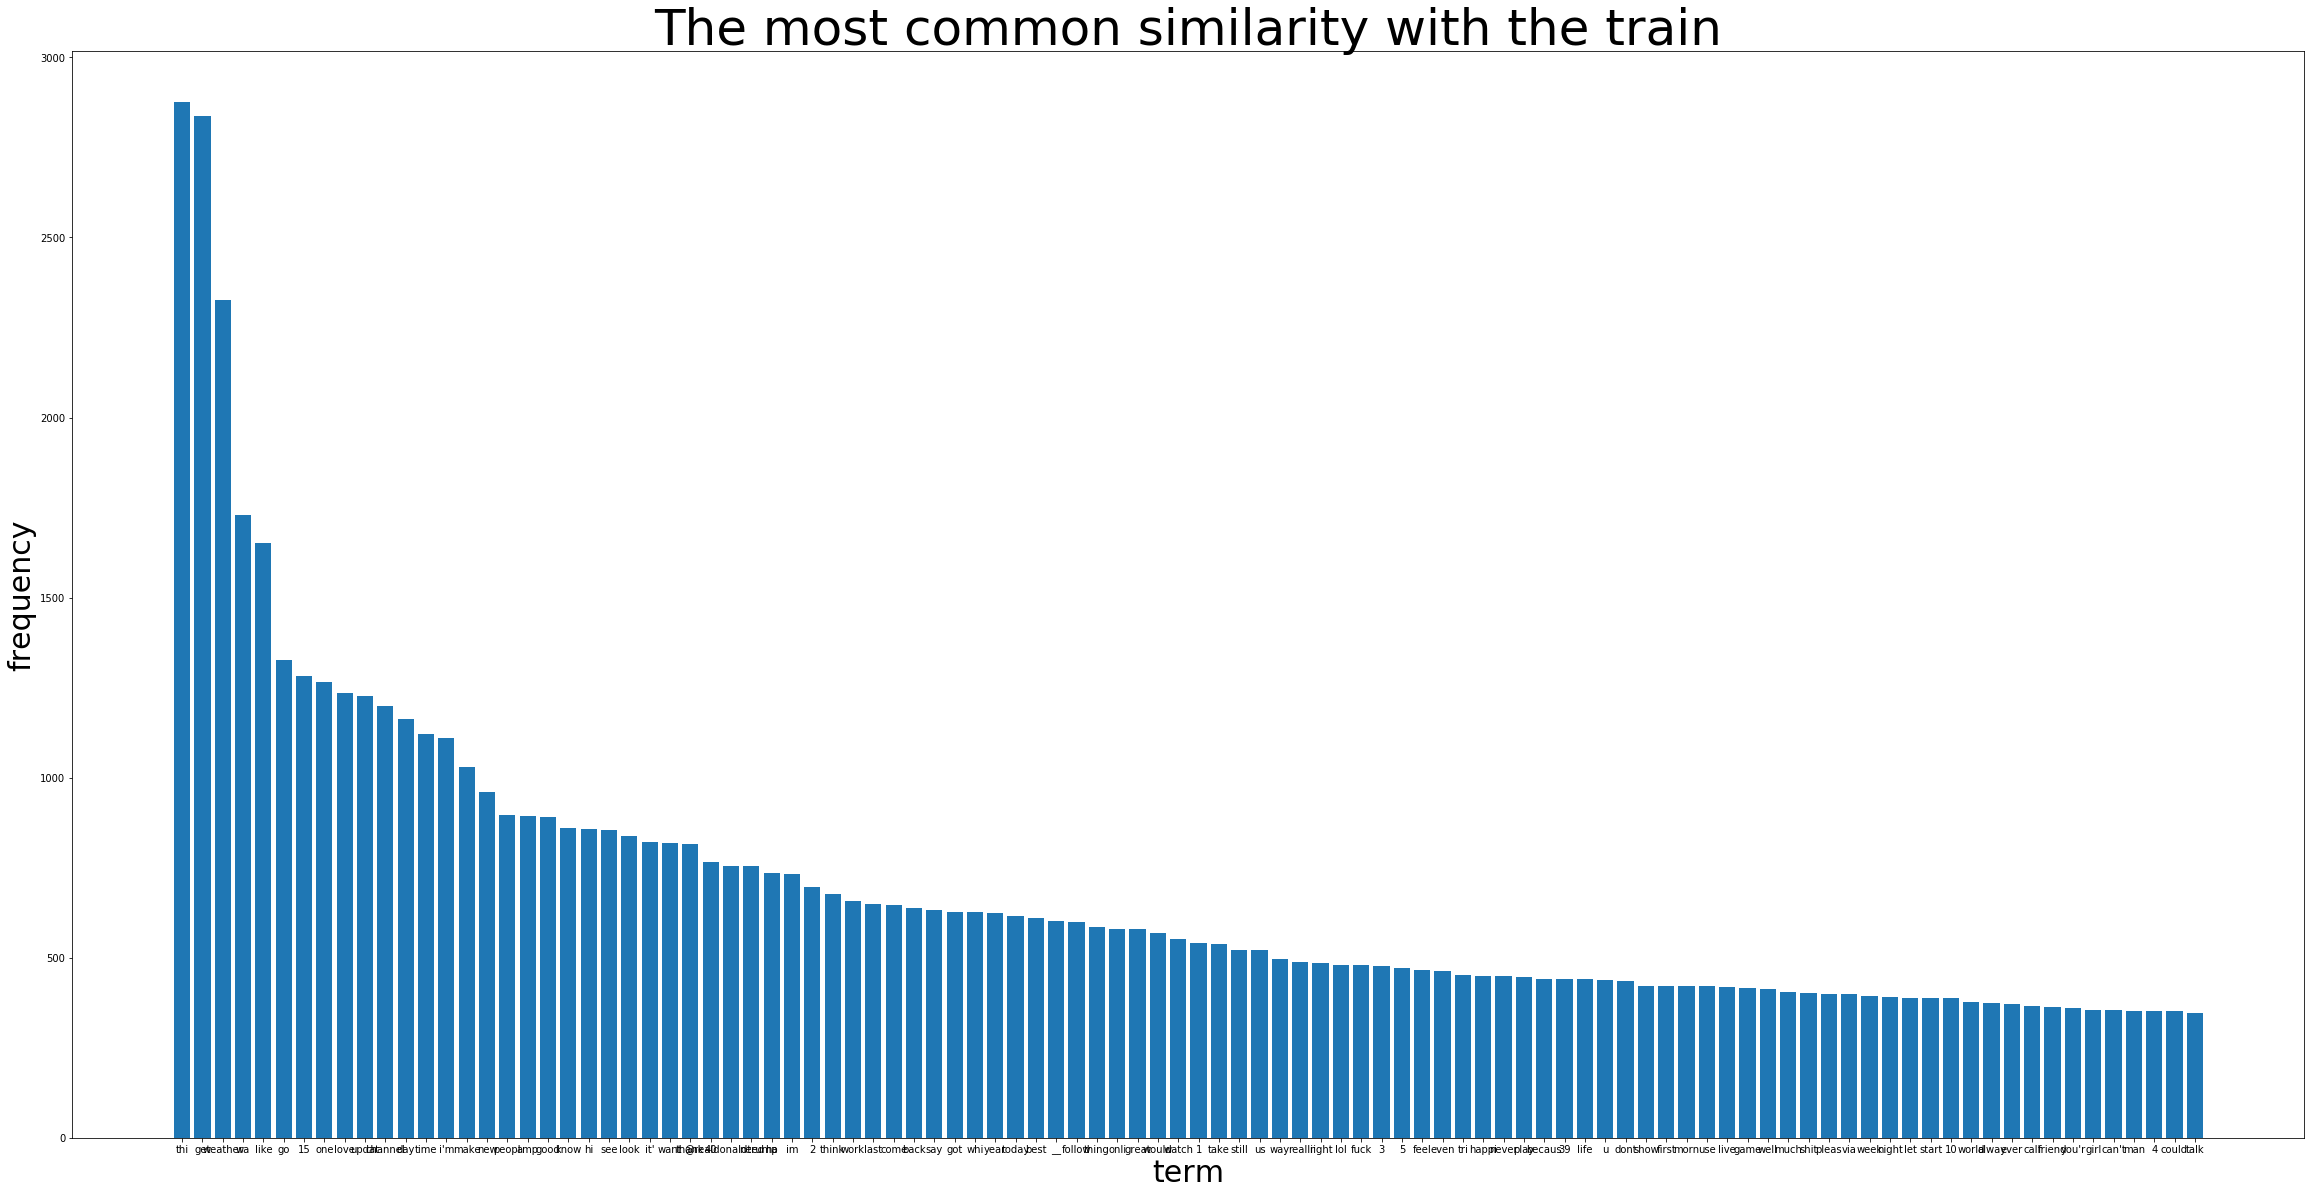

In [24]:
intersection = Counter()

for word in terms_tweets.keys():
    if word in terms_all_genders.keys():
        intersection[word] = terms_tweets[word] + terms_all_genders[word]
        
keys = []
values = []
for x, y in intersection.most_common(100):
    keys.append(x)
    values.append(y)
plt.figure(figsize=(40,20))
plt.bar(keys, values)
plt.title("The most common similarity with the train", fontsize=50)
plt.xlabel("term", fontsize=30)
plt.ylabel("frequency", fontsize=30)

Indeed, some of the words that are common in dataset are also common in tweets we've collected from Twitter. There are common overlapping words.

## Question 4

### Use the best gender classification prediction model which was trained on Question 2 to predict the gender of the authors of collected tweets:

In [25]:
# Extracting features new tweets
tweets = vectorizer.transform(df.text)
print("n_samples: %d, n_features: %d" % tweets.shape)
print()

n_samples: 15000, n_features: 35018



In [26]:
# fit SVM model and predict on the new tweets
clf = SGDClassifier(max_iter=10)
clf.fit(X_train, y_train)

pred = clf.predict(tweets)

### Present the prediction results:

In [27]:
df['Gender'] = pred
df

,name,screen_name,text,hashtags,Gender
0,AlvarezNestor,alvareznestor,Esta es una de las tantas personas que se lucr...,[],brand
1,austyn,_poopeye,Idk how mfs ain’t learning 😂😭😭stuuuupidddd,[],female
2,Keith Rettig,KeithRettig2,Shows just how far out of touch she is unreal,[],male
3,Nellie,nell20_45,@TravisAllen02 I love how petty this is https:...,[],brand
4,"John Halloran, SCPS",Halloran_J,Fred Rogers would approve,[],male
5,Adonis,AdonisG07,Give this a quick read please😁 https://t.co/hP...,[],brand
6,Ann Marie White,AnnMari11331462,@JackConnie @PenelopeRuzy @BravoHWFanClub Than...,[],female
7,Ellen Stanton,judecreek2,@krassenstein @realDonaldTrump Unlike Hillary....,[],male
8,MrBowler,rgcappy1,@southerndivine Not. Of. The. Time.,[],female
9,Stefan Pokorny,stefandwarven,@Quil244 https://t.co/c6UzJaMfX5,[],brand


### Present the your conclusions:

As part of the work we downloaded the dataset from kaggle and performed a pre-processing process.

We trained the model using the tf-idf vectorizer.
The models we have chosen for the artist are:
1. svm
2. perceptron
3. sequntial
The latest model is a model of keras.

The model that gave us the highest accuracy is the SVM model.

With the help of the Twitter API we took 15,000 tweets.

On the tweets we run the SVM model.

The results are presented in the table in an orderly manner.
You can see that our model categorized them by male, female and brand.